In [1]:
# font
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [2]:
# google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
# import 라이브러리
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings

# 경고문 출력 방지
warnings.filterwarnings(action='ignore')

# visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import seaborn as sns

# 브라우저에서 바로 그려지도록 
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# row 생략 없이 출력
# pd.set_option('display.max_rows', None)
# col 생략 없이 출력
# pd.set_option('display.max_columns', None)

# 데이터 수집

In [4]:
# csv 파일 읽어오기
train_file_path = "/gdrive/MyDrive/HorseRacingPrediction/data/train.csv"
test_file_path = "/gdrive/MyDrive/HorseRacingPrediction/data/test.csv"
sm_file_path = "/gdrive/MyDrive/HorseRacingPrediction/data/sample_submission.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
sm_df = pd.read_csv(sm_file_path)

# 1,2위 데이터 필터링
first_prize = train_df[train_df['ord'] == 1]
second_prize = train_df[train_df['ord'] == 2]
winner_df = pd.concat([first_prize, second_prize])
winner_df[winner_df['rcDate'].isin(pd.date_range('2021-01-08','2021-01-14'))]

,rcDate,rcNo,chulNo,hrNo,age,ageCond,budam,chaksunT,chaksunY,chaksun_6m,...,sex,wgBudam,track,weather,waterRate,ord,rcTime,jkNo,trNo,owNo


# 데이터 탐색

In [5]:
# 데이터 확인하기
print(f'데이터셋 크기 : {train_df.shape}')
print(f'데이터셋 크기 : {test_df.shape}')

데이터셋 크기 : (7064, 35)
데이터셋 크기 : (654, 33)


In [38]:
# 데이터 확인
train_df.head()

,rcDate,rcNo,chulNo,hrNo,age,ageCond,budam,chaksunT,chaksunY,chaksun_6m,...,sex,wgBudam,track,weather,waterRate,ord,rcTime,jkNo,trNo,owNo
0,20210108,1,1,43108,3,연령오픈,별정A,0,0,0,...,수,56.5,건조,맑음,3,11,66.1,80438,70128,118030
1,20210108,1,2,42271,3,연령오픈,별정A,0,0,0,...,거,52.5,건조,맑음,3,12,68.4,80601,70086,104133
2,20210108,1,3,42905,3,연령오픈,별정A,0,0,0,...,수,56.5,건조,맑음,3,9,65.9,80588,70129,112286
3,20210108,1,4,42445,3,연령오픈,별정A,0,0,0,...,암,54.5,건조,맑음,3,7,65.2,80532,70135,112274
4,20210108,1,5,42583,3,연령오픈,별정A,0,0,0,...,거,56.5,건조,맑음,3,6,64.8,80421,70137,110050


In [79]:
sm_df.head()

,rcDate,rcNo,pred1,pred2,pred3
0,20220130,1,3-5,3-7,5-7


# 데이터 전처리

In [7]:
# 경주일자 컬럼 날짜형식으로 변환
# from datetime import datetime

# df['rcDate'] = df['rcDate'].astype(str)
# df['rcDate'] = pd.to_datetime(df['rcDate'])

# df['rcDate'] = df['rcDate'].apply(lambda _ : datetime.strptime(_,'%Y%m%d'))
# print(df['rcDate'])

# df['Year'] = df['rcDate'].dt.year
# df['Month'] = df['rcDate'].dt.month

# df.head()

In [8]:
# 분석하지 않을 변수 제외하기 (순위, 경기기록(초))
# train_df2 = train_df.drop(['ord','rcTime'], axis=1, inplace=False)
train_df2 = train_df.drop(columns = ['ord', 'rcTime'])
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7064 entries, 0 to 7063
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rcDate      7064 non-null   int64  
 1   rcNo        7064 non-null   int64  
 2   chulNo      7064 non-null   int64  
 3   hrNo        7064 non-null   int64  
 4   age         7064 non-null   int64  
 5   ageCond     7064 non-null   object 
 6   budam       7064 non-null   object 
 7   chaksunT    7064 non-null   int64  
 8   chaksunY    7064 non-null   int64  
 9   chaksun_6m  7064 non-null   int64  
 10  dusu        7064 non-null   int64  
 11  ilsu        7064 non-null   int64  
 12  ord1CntT    7064 non-null   int64  
 13  ord1CntY    7064 non-null   int64  
 14  ord2CntT    7064 non-null   int64  
 15  ord2CntY    7064 non-null   int64  
 16  ord3CntT    7064 non-null   int64  
 17  ord3CntY    7064 non-null   int64  
 18  prd         7064 non-null   object 
 19  prizeCond   7064 non-null  

In [9]:
all_df = pd.concat([train_df2, test_df])

In [10]:
cat_cols = test_df.columns[test_df.dtypes == object]
cat_cols

Index(['ageCond', 'budam', 'prd', 'prizeCond', 'rank', 'rating', 'sex',
       'track', 'weather'],
      dtype='object')

In [11]:
from sklearn.preprocessing import LabelEncoder
# 라벨 인코딩(문자 -> 숫자)
le = LabelEncoder()
for i in cat_cols:
    all_df[i] = le.fit_transform(list(all_df[i]))
all_df

,rcDate,rcNo,chulNo,hrNo,age,ageCond,budam,chaksunT,chaksunY,chaksun_6m,...,rcCntY,rcDist,sex,wgBudam,track,weather,waterRate,jkNo,trNo,owNo
0,20210108,1,1,43108,3,4,0,0,0,0,...,0,1000,1,56.5,0,0,3,80438,70128,118030
1,20210108,1,2,42271,3,4,0,0,0,0,...,0,1000,0,52.5,0,0,3,80601,70086,104133
2,20210108,1,3,42905,3,4,0,0,0,0,...,0,1000,1,56.5,0,0,3,80588,70129,112286
3,20210108,1,4,42445,3,4,0,0,0,0,...,0,1000,2,54.5,0,0,3,80532,70135,112274
4,20210108,1,5,42583,3,4,0,0,0,0,...,0,1000,0,56.5,0,0,3,80421,70137,110050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,20220130,6,9,43191,4,4,2,232710000,185150000,130350000,...,12,1400,1,52.0,0,0,2,80484,70086,201269
650,20220130,6,10,38065,8,4,2,462550000,28500000,0,...,6,1400,0,52.0,0,0,2,80434,70128,113115
651,20220130,6,11,38180,8,4,2,358200000,0,0,...,2,1400,2,51.0,0,0,2,80482,70141,104131
652,20220130,6,13,36510,9,4,2,1470900000,19800000,19800000,...,6,1400,1,55.5,0,0,2,80600,70136,105040


In [12]:
# 전처리한 데이터 분리하기
train_df3 = all_df[:len(train_df2)]
test_df2 = all_df[len(train_df):]

# 데이터 시각화(EDA)

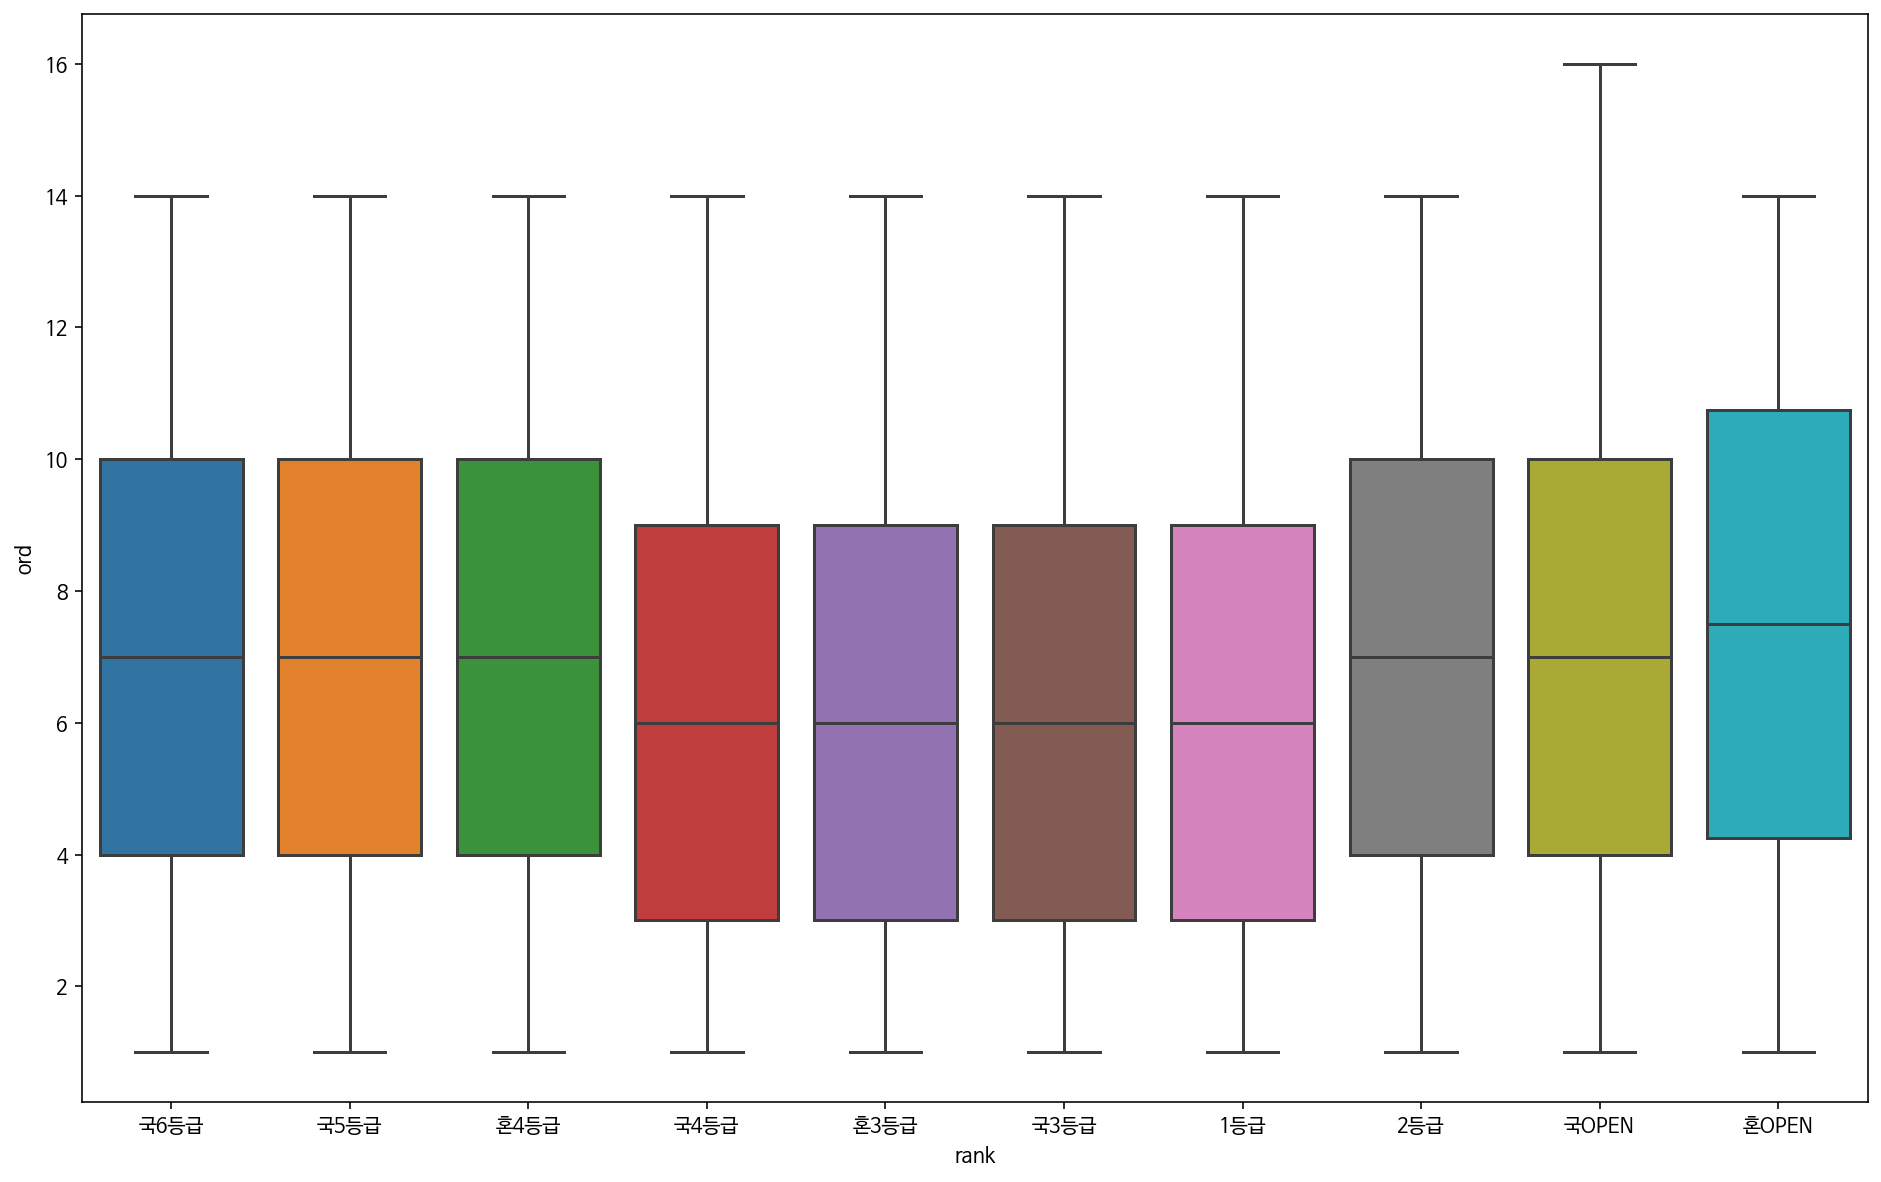

In [13]:
plt.figure(figsize = (16,10))
sns.boxplot(train_df['rank'], train_df['ord'])

In [14]:
# 1, 2등 말의 성별
# fig, ax = plt.subplots(figsize=(10,6))
# fig =sns.countplot(x=winner_df['sex'])
# plt.show()

In [15]:
# 1, 2등이 가장 많은 연령 분포
# fig, ax = plt.subplots(figsize=(10,6))
# fig = sns.kdeplot(x=winner_df['age'])
# plt.show()

In [16]:
# 1,2등이 가장 많이 나온 트랙
# fig, ax = plt.subplots(figsize=(10,6))
# fig = sns.countplot(x=winner_df['track'])
# plt.show()

In [17]:
# 경마장 함수율
# fig, ax = plt.subplots(figsize=(10,6))
# fig = sns.countplot(x=winner_df['waterRate'])
# plt.show()

- 트랙상태와 연관이 있어보인다

In [18]:
# 경기수가 가장 많은 연령제한
# fig, ax = plt.subplots(figsize=(10,6))
# fig = sns.countplot(x=winner_df['ageCond'])
# plt.show()

- 3세를 기준으로 나뉘어 3세가 출전 가능한 경기가 많다.

In [19]:
# 1,2 등 말의 등급
# fig, ax = plt.subplots(figsize=(10,6))
# fig = sns.countplot(x=winner_df['rank'].sort_values(ascending=False))
# plt.show()

In [20]:
# 연령제한경기별 1,2등 말의 연령
# fig, ax = plt.subplots(figsize=(10,6))
# fig = sns.boxplot(x=winner_df['age'], y=winner_df['ageCond'])
# plt.show()

- 3세이상 경기(1경기)에서 4세(1등), 6세 (2등)

In [21]:
# 경주거리별 상금조건
# sns.stripplot(x=winner_df['rcDist'], y=winner_df['prizeCond'])

# 모델 선별

## RandomForest

In [22]:
from sklearn.ensemble import RandomForestRegressor 
#모델 선언
rf = RandomForestRegressor(n_jobs = 4, random_state = 42)
#모델 학습
rf.fit(train_df3, train_df['ord'])
# 테스트셋 예측
result_cas = rf.predict(test_df2)

In [23]:
print(f'Accuracy on training set : {rf.score(train_df3, train_df["ord"])}')

Accuracy on training set : 0.8880269309195373


In [24]:
pd.DataFrame({'rcDate': test_df.rcDate, 'pred': result_cas}).set_index('rcDate').to_csv('/gdrive/MyDrive/HorseRacingPrediction/sub.csv')

# LinearRegression

In [47]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(
    train_df3, train_df['ord'], test_size=0.3
)

In [48]:
len(train_df3), len(train_data), len(test_data)

(7064, 4944, 2120)

Multivariate Regression 학습

In [49]:
# 다변량 회귀식 x1가 0.5 x2가 2증가하면 x2가 증가할떄 더 많이 증가 -> 영향 증가
from sklearn.linear_model import LinearRegression

multi_regressor = LinearRegression()
multi_regressor.fit(train_data, train_target)

LinearRegression()

회귀식 확인

In [51]:
# 편향 확인
multi_regressor.intercept_

21404.668986887955

In [52]:
# 계수 확인
multi_regressor.coef_

array([-1.04138655e-03,  3.38112703e-02,  8.64094696e-02, -1.24091216e-04,
        2.36136994e-01, -6.15203537e-02,  7.41168256e-02, -9.69832869e-10,
        4.25885434e-09, -2.60841209e-08,  4.59158446e-01,  2.13493136e-02,
       -8.90057432e-02, -3.98285374e-01, -4.36270124e-02, -5.47617571e-01,
       -1.15801007e-01, -2.40480749e-01,  8.35357275e-02,  1.44011128e-02,
        5.40989470e-02,  7.42490374e-03,  2.53516709e-02, -2.23651809e-02,
        5.56411050e-04,  2.07910582e-01, -9.01240522e-02, -2.31021773e-02,
        1.69950585e-02,  2.10340843e-02, -1.94597003e-05, -4.95299300e-03,
       -6.33526421e-06])

예측

In [53]:
multi_train_pred = multi_regressor.predict(train_data)
multi_test_pred = multi_regressor.predict(test_data)

평가 

In [54]:
# 실제 값의 부호보다는 크기만 보고 싶다 -> 차이의 크기를 반영하기 위해 제곱을 하고 평균을 구함
# 값이 작을수록 잘 예측
from sklearn.metrics import mean_squared_error

multi_train_mse = mean_squared_error(multi_train_pred, train_target)
multi_test_mse = mean_squared_error(multi_test_pred, test_target)

In [55]:
print(f'Multi Regression Train MSE is {multi_train_mse:.4f}')
print(f'Multi Regression Test MSE is {multi_test_mse:.4f}')

Multi Regression Train MSE is 10.8296
Multi Regression Test MSE is 11.4576


## Ridge Regression

In [56]:
from sklearn.linear_model import Ridge

ridge_regressor = Ridge()
ridge_regressor.fit(train_data, train_target)

Ridge()

In [59]:
ridge_regressor.intercept_

21399.101166086228

In [60]:
ridge_regressor.coef_

array([-1.04111157e-03,  3.38325854e-02,  8.64116658e-02, -1.24290383e-04,
        2.35653012e-01, -6.14310905e-02,  7.38145422e-02, -9.68202076e-10,
        4.24086427e-09, -2.60953926e-08,  4.59109694e-01,  2.13427990e-02,
       -8.90534148e-02, -3.97667801e-01, -4.37429462e-02, -5.47091476e-01,
       -1.15807457e-01, -2.40218137e-01,  8.32801736e-02,  1.43726947e-02,
        5.40837771e-02,  7.43095742e-03,  2.53802965e-02, -2.24120754e-02,
        5.56049057e-04,  2.07780098e-01, -9.01815003e-02, -2.31037693e-02,
        1.70050145e-02,  2.10315329e-02, -1.96040825e-05, -4.95246890e-03,
       -6.33495476e-06])

예측

In [62]:
ridge_train_pred = ridge_regressor.predict(train_data)
ridge_test_pred = ridge_regressor.predict(test_data)

평가

In [63]:
ridge_train_mse = mean_squared_error(ridge_train_pred, train_target)
ridge_test_mse = mean_squared_error(ridge_test_pred, test_target)

In [65]:
print(f'Ridge Regression Train MSE is {ridge_train_mse:.4f}')
print(f'Ridge Regression Test MSE is {ridge_test_mse:.4f}')

Ridge Regression Train MSE is 10.8296
Ridge Regression Test MSE is 11.4575


LASSO Regression

In [66]:
from sklearn.linear_model import Lasso

lasso_regressor = Lasso()
lasso_regressor.fit(train_data, train_target)

Lasso()

회귀식 확인

In [67]:
lasso_regressor.intercept_

7926.089759751851

In [68]:
lasso_regressor.coef_

array([-3.78046527e-04,  0.00000000e+00,  4.42802428e-02, -2.33709454e-04,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -7.69663387e-10,
       -1.48236039e-08, -3.91455245e-08,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  7.41902010e-03,  4.18599161e-03, -0.00000000e+00,
       -1.07420165e-04,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.31305040e-04, -4.54842628e-03,
       -5.91156371e-06])

예측

In [72]:
lasso_train_pred = lasso_regressor.predict(train_data)
lasso_test_pred = lasso_regressor.predict(test_data)

In [73]:
lasso_train_mse = mean_squared_error(lasso_train_pred, train_target)
lasso_test_mse = mean_squared_error(lasso_test_pred, test_target)

In [75]:
print(f'LASSO Regression Train MSE is {lasso_train_mse:.4f}')
print(f'LASSO Regression Test MSE is {lasso_test_mse:.4f}')

LASSO Regression Train MSE is 11.6262
LASSO Regression Test MSE is 12.0785


In [77]:
print(f"Multi Regression Test MSE is {multi_test_mse:.4f}")
print(f"Ridge Regression Test MSE is {ridge_test_mse:.4f}")
print(f"LASSO Regression Test MSE is {lasso_test_mse:.4f}")

Multi Regression Test MSE is 11.4576
Ridge Regression Test MSE is 11.4575
LASSO Regression Test MSE is 12.0785


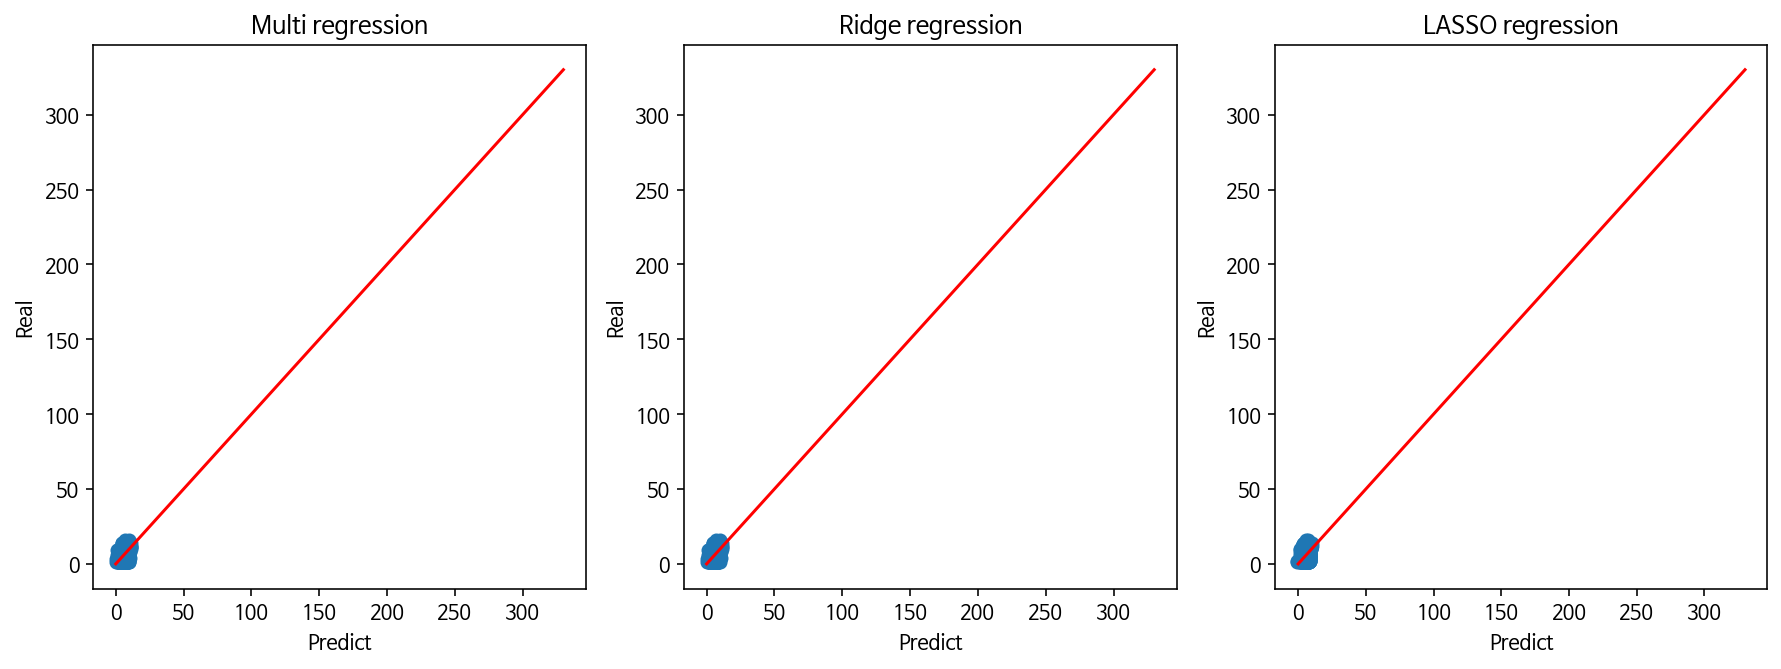

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
preds = [
    ("Multi regression", multi_test_pred),
    ("Ridge regression", ridge_test_pred),
    ("LASSO regression", lasso_test_pred),
]

for idx, (name, test_pred) in enumerate(preds):
    ax = axes[idx]
    ax.scatter(test_pred, test_target)
    ax.plot(np.linspace(0, 330, 100), np.linspace(0, 330, 100), color="red")
    ax.set_xlabel("Predict")
    ax.set_ylabel("Real")
    ax.set_title(name)